
# Homework 1, STAT 4609

***

For the first homework assignment of the course, you will implement a linear regression model from scratch and then extend your linear regression code for implementing ridge regression. We will provide you with the basic template for a creating a standalone module for fitting linear regression to data. Your task is to implement the code to learn the regression parameters. In this assignment, the only extra Python package you are allowed to use is Numpy.

***

Assume here we have a regression model $Y = X\beta + \epsilon$, where $\epsilon \sim \mathcal{N}(0,\sigma^2 I)$.

1.) On a .pdf file submitted together with this assignment, please derive the maximum likelihood estimator for  the regression weights, $\beta$, and the noise parameter, $\sigma^2$. Show that the MLE for the linear regression model is identical to the OLS solution. You will need to derive these estimators correctly to do the rest of the assignment properly.

2.) Here, you will implement a Python class which contains an object that will fit a linear regression model.


In [5]:
import numpy as np

class LinearRegression(object):
    
    def __init__(self, X, Y):
        self.X, self.Y = X, Y
        self.n, self.p = X.shape
    
    def fit(self):
        X, Y, n, p = self.addIntercept(self.X, self.n), self.Y, self.n, self.p
        #compute MLEs
        self.beta = np.linalg.inv(X.T @ X) @ X.T @ Y
        e = Y - X @ self.beta #compute residual term
        self.sigma2 = np.sum(e**2) / (n - p - 1)
        
    def predict(self, X_test):
        X_test = self.addIntercept(X_test, len(X_test))
        Y_pred = X_test @ self.beta
        return Y_pred

    def addIntercept(self, X, n):
        return np.hstack((np.ones((n, 1)), X))

    def MSE(self, pred, real):
        return np.mean(np.square(pred - real))

    def rankCovariates(self, covariates, values):
        #this function returns the ranking of covariates based on its importance towards the output values
        # the covariates are the names of columns and values are the values being compared.
        return sorted(zip(covariates, values), key=lambda x: abs(x[1]), reverse=True)


3.) Train the linear regression code you wrote on the "Boston Housing" dataset, which is a collection of median housing price data in the U.S. city of Boston and associated covariate data. You can read more information about this dataset here: http://lib.stat.cmu.edu/datasets/boston. You should include an intercept term (a column of "ones" for the input data). The intercept term represents the mean value of the response when all covariates are equal to zero. 

Split the dataset into a training set consisting of the first 400 observations and a test set consisting of the last 106 observations. 

Train the model on the training data and predict the median housing prices on the test set. 

Compute the mean squared error between the predicted housing prices and the actual housing prices. 

List the covariates from most important to least according to size of the regression coefficient. 

What are the most important variables that determine median house prices in Boston?

In [7]:
boston = np.loadtxt("BostonHousing.csv", skiprows=1, delimiter=",")
covariates = np.loadtxt("BostonHousing.csv", max_rows=1, delimiter=",", dtype=str)
covariates = np.hstack((covariates[:-1],"intercept"))
#covariates: ['crim' 'zn' 'indus' 'chas' 'nox' 'rm' 'age' 'dis' 'rad' 'tax' 'ptratio' 'b' 'lstat' 'intercept']

X, Y = boston[:,0:-1], boston[:,[-1]] # shape: (506, 13) (506,1)

#split the dataset into a training set and a test set
train_X, test_X = X[:400,:], X[400:,:] # shape => (400,13), (106,13)
train_Y, test_Y = Y[:400,:], Y[400:,:]

# Fit the linear regression model here 
LR = LinearRegression(train_X, train_Y)
LR.fit()

#predict Y
predicted_Y = LR.predict(test_X)

#compute MSE
LR_MSE = LR.MSE(predicted_Y, test_Y)
print("Test MSE: %.2f" % LR_MSE)

#covariates with high absolute beta values influence the Y value more. 
ranked_covariates = LR.rankCovariates(covariates, LR.beta)
print("Ranked Covariates:\n\t%s" % "\n\t".join([f"{covariate}: {coefficient[0]:.2f}" for covariate, coefficient in ranked_covariates]))


Test MSE: 37.89
Ranked Covariates:
	crim: 28.67
	rm: -15.00
	age: 4.89
	nox: 1.72
	rad: -1.29
	b: -0.81
	intercept: -0.52
	tax: 0.48
	zn: -0.19
	chas: 0.06
	indus: 0.04
	ptratio: -0.02
	dis: 0.00
	lstat: -0.00


4.) Now, derive the regression coefficient parameter, $\hat{\beta}$ by minimzing the sum of squared errors with  L2 regularization of the regression coeffiecients (under a scalar regularization parameter $\lambda$). This is known as ridge regression. First, write the objective function you are optimizing. Then solve for the optimal solution (this is available in closed form).

5.) Now write a Python class that implements ridge regression. You should inherit the LinearRegression class you wrote earlier as a simple way to reduce some of redundant code you will need to write. Read more about class inheritance here: https://www.w3schools.com/python/python_inheritance.asp

Next, write a function called "fit_lambda" inside your ridge regression object that selects the regularization term on some grid of values that minimizes the mean squared error on some given test set data.

In [11]:
class RidgeRegression(LinearRegression):
    def __init__(self, X, Y, lambda_reg=None):
        super().__init__(X, Y)
        self.lambda_reg = lambda_reg

    def fit(self):
        if self.lambda_reg is None:
            raise ValueError("lambda_reg must be initialised before calling fit()")
            
        lambda_ = self.lambda_reg
        X, Y, n, p = self.addIntercept(self.X, self.n), self.Y, self.n, self.p

        # L2 regularisation
        self.beta = np.linalg.inv(X.T @ X + lambda_ * np.identity(p+1)) @ (X.T @ Y)
        
    def fit_lambda(self, lambdas, X_test, Y_test):
        self.allMse = []
        best_mse = float("inf") #initialise as an arbitrarily big float

        for lambda_ in lambdas:
            self.lambda_reg = lambda_
            self.fit()  # fit the model with the current lambda and the training set
            Y_pred = self.predict(X_test)
            mse = self.MSE(Y_pred, Y_test)
            self.allMse.append(mse)
            
            if mse < best_mse:
                best_mse = mse
                best_lambda = lambda_
                best_beta = self.beta

        self.lambda_reg = best_lambda
        self.beta = best_beta
        return best_lambda, best_mse


6.) Now fit your ridge regression code on the Boston data set from question 2. Use the "fit_lambda" method you implemented in the previous question to select the regression parameter. 

What are the most important covariates that affect median home prices under ridge regression? 

Next, generate a plot with the grid of candidate regularization parameters on the X-axis and the test set MSE on the Y-axis (please label your plot appropriately). 

Compare the test MSE under the optimal regularization parameter for ridge regression with the test set MSE from question 3. How do they compare? 

If you implemented the code correctly, then ridge regression should produce a smaller test set MSE than the OLS result. Why is this the case? 

Do you think the method for selecting the regularization parameter implemented in the code is appropriate? Why or why not?

Ranked Covariates:
	age: 5.35
	nox: 0.97
	rad: -0.88
	crim: 0.84
	intercept: -0.53
	b: -0.40
	tax: 0.36
	zn: -0.20
	rm: 0.10
	indus: 0.05
	chas: 0.03
	lstat: 0.02
	ptratio: -0.01
	dis: 0.01


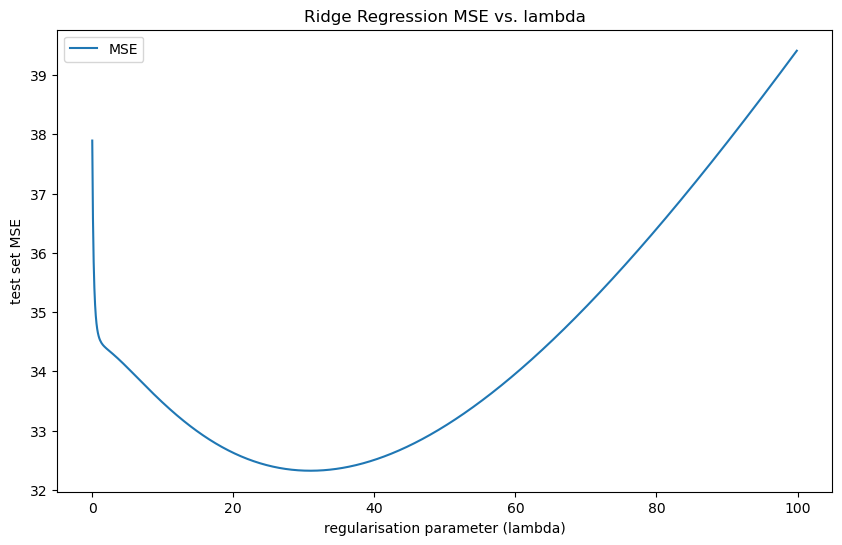

Ridge Regression MSE: 32.32
OLS Test MSE: 37.89


In [12]:
import matplotlib.pyplot as plt 

RR = RidgeRegression(train_X, train_Y)
grid = np.arange(0,100,.1) #lambda grid

#select lambda
lambda_, RR_MSE = RR.fit_lambda(grid, test_X, test_Y)

#rank covariates by importance
ranked_covariates = RR.rankCovariates(covariates, RR.beta)
print("Ranked Covariates:\n\t%s" % "\n\t".join([f"{covariate}: {coefficient[0]:.2f}" for covariate, coefficient in ranked_covariates]))

# Plot of lambdas vs. the mse
plt.figure(figsize=(10, 6))
plt.plot(grid, RR.allMse, label='MSE')
plt.xlabel('regularisation parameter (lambda)')
plt.ylabel('test set MSE')
plt.title('Ridge Regression MSE vs. lambda')
plt.legend()
plt.show()

# RR MSE vs. LR(OLS) MSE
print("Ridge Regression MSE: %.2f" % RR_MSE)
print("OLS Test MSE: %.2f" % LR_MSE)